# load all drifter deployments available and process

In [6]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas  # noqa

import pynsitu as pin
crs = pin.maps.crs

In [7]:
## taos

root_dir = "/Users/aponte/Current_Projects/taos/campagnes/"

rpaths = [
    "taos0/drifters0/taos0_drifters0.yaml",
    "taos0/drifters1/taos0_drifters1.yaml",
    "taos1/drifters0/taos1_drifters0.yaml",
    "taos1/drifters1/taos1_drifters1.yaml",
    "taos2/drifters0/taos2_drifters0.yaml",
    "taos2/drifters1/taos2_drifters1.yaml",
    "drifters_lern/lern_drifters.yaml",
]

C = {}
for rp in rpaths:
    cp = pin.Campaign(os.path.join(root_dir, rp))
    C[cp["name"]] = cp

<Axes: >

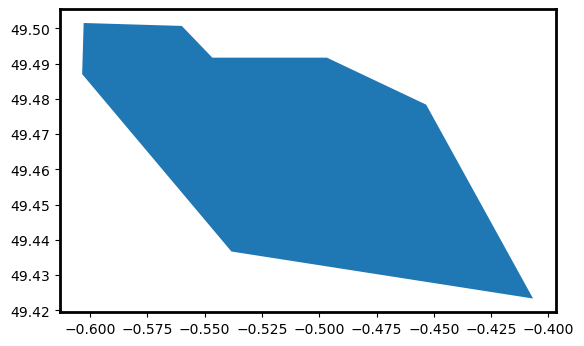

In [8]:
# load courseulles location
#gpd.read_file("courseulles_0.zip")
cours = gpd.read_file("courseulles_0/courseulles.shp")
cours.plot()

In [9]:
#df = cp.load('drifters.nc', toframe=True).reset_index()
#df["id"].astype(int).astype(str)
#df["id"].dtype == float

In [10]:
from pandas.api.types import is_numeric_dtype

def load_drifters(cp):
    df = cp.load('drifters.nc', toframe=True).reset_index()
    #fix id dtype
    if is_numeric_dtype(df["id"].dtype):
        df["id"] = df["id"].astype(str)
    df["id"] = df.apply(lambda row: cp["name"]+f"_"+row["id"]+"_"+row["deployment"], axis=1)
    return df

df = pd.concat([load_drifters(cp) for c, cp in C.items()]).set_index("id")

# taos deployments
dft = df.loc[df.index.str.contains('taos')]
# lern deployments
dfl = df.loc[df.index.str.contains('lern')]

In [11]:
df.head()

,time,BatteryStatus,CommId,GPS Confidence,GPS Fail Counter,GpsQuality,latitude,longitude,deployment,platform,...,acceleration_north,acceleration,DataId,index,AgeInSeconds,BatteryVoltage,submerged,temperature,project,SamplingRate
id,,,,,,,,,,,,,,,,,,,,,
taos0_drifters0_0-4351896_d0,2022-05-11 05:10:00,GOOD,0-4351896,0.0,0.0,3.0,49.339996,-0.243812,d0,drifter0,...,-0.000002,0.000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taos0_drifters0_0-4351896_d0,2022-05-11 05:11:00,GOOD,0-4351896,0.0,0.0,3.0,49.339957,-0.243543,d0,drifter0,...,-0.000002,0.000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taos0_drifters0_0-4351896_d0,2022-05-11 05:12:00,GOOD,0-4351896,0.0,0.0,3.0,49.339917,-0.243276,d0,drifter0,...,-0.000002,0.000026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taos0_drifters0_0-4351896_d0,2022-05-11 05:13:00,GOOD,0-4351896,0.0,0.0,3.0,49.339878,-0.243010,d0,drifter0,...,-0.000002,0.000026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taos0_drifters0_0-4351896_d0,2022-05-11 05:14:00,GOOD,0-4351896,0.0,0.0,3.0,49.339838,-0.242745,d0,drifter0,...,-0.000002,0.000026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

## general statistics

### number of deployments

In [12]:
N = df.index.unique().size

Nt = dft.index.unique().size

print(f"Number of drifter deployments = {N}")
print(f"Number of TAOS drifter deployments = {Nt}")
print(f"Number of LERN drifter deployments = {N-Nt}")

Number of drifter deployments = 70
Number of TAOS drifter deployments = 38
Number of LERN drifter deployments = 32


### compute number of days of drift

In [13]:
def deployment_durations(df):
    df = df.sort_values("time")
    return pd.Series(dict(durations= (df["time"].iloc[-1]-df["time"].iloc[0])/pin.day) )

du = df.groupby(df.index).apply(deployment_durations)
dut = dft.groupby(dft.index).apply(deployment_durations)
dul = dfl.groupby(dfl.index).apply(deployment_durations)

In [14]:
du_tot = du.sum()
dut_tot = dut.sum()
dul_tot = dul.sum()

print(f"total duration = {float(du_tot):.1f} days")
print(f"TAOS total duration = {float(dut_tot):.1f} days")
print(f"LERN total duration = {float(dul_tot):.1f} days")

total duration = 393.5 days
TAOS total duration = 146.4 days
LERN total duration = 247.1 days


In [15]:
# https://davidmathlogic.com/colorblind/##FFC20A-#0C7BDC
c_taos = "#FFC20A"
c_lern = "#0C7BDC"

Text(0.5, 1.0, 'deployment durations')

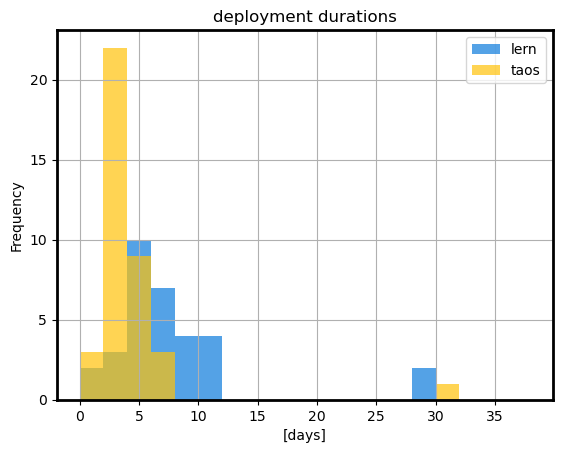

In [16]:
bins = np.arange(0,40,2)

fig, ax = plt.subplots(1,1)

#du.rename(columns=dict(durations="deployment durations")).plot.hist(ax=ax, bins=bins)
dul.rename(columns=dict(durations="lern")).plot.hist(ax=ax, bins=bins, color=c_lern, alpha=0.7)
dut.rename(columns=dict(durations="taos")).plot.hist(ax=ax, bins=bins, color=c_taos, alpha=0.7)

ax.grid()
ax.set_xlabel("[days]")
ax.set_title("deployment durations")

### everything on a map

In [48]:
bounds=[-2.3, 1.4, 49.2, 50.65] # larger area
bounds = [-1.3, 0.3, 49.25, 49.7]

keys = sorted(list(df.index.unique()))

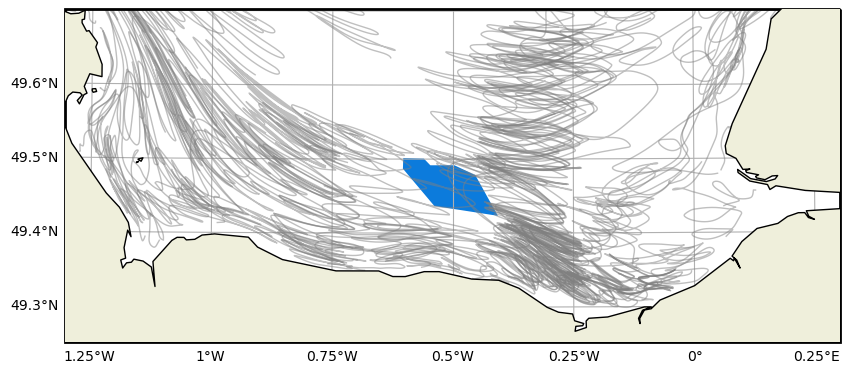

In [49]:
fig, ax, cbar = cp.map(extent=bounds, rivers=False, coastlines="i", figsize=(10,10))

cours.to_crs(crs).plot(ax=ax, color=c_lern, transform=crs)

lw, c = 1, "0.5"
for k in keys:
    _df = df.loc[k].set_index("time").sort_index()
    #alpha = 1 if "taos" in k else 0.5
    ax.plot(_df.longitude, _df.latitude, color=c, label=k,
            alpha=0.5, lw=lw,
            transform=crs, 
           )

#ax.set_extent(bounds)

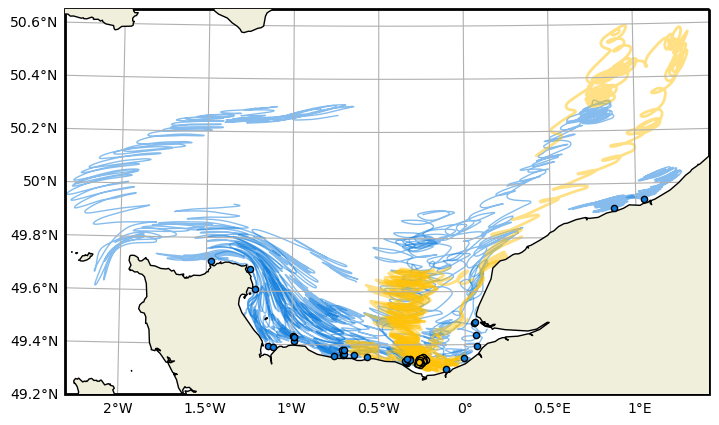

In [13]:
fig, ax, cbar = cp.map(extent=bounds, rivers=False)
# rivers are not displayed correctly

for k, c in zip(keys, colors):
    _df = df.loc[k].set_index("time").sort_index()
    #c = "cadetblue" if "taos" in k else "0.5"
    c = c_taos if "taos" in k else c_lern
    lw = 2 if "taos" in k else 1
    #alpha = 1 if "taos" in k else 0.5
    ax.plot(_df.longitude, _df.latitude, color=c, label=k,
            alpha=0.5, lw=lw,
            transform=pin.maps.crs, 
           )

# add start locations
for k, c in zip(keys, colors):
    #c = "cadetblue" if "taos" in k else "0.1"
    c = c_taos if "taos" in k else c_lern
    _df = df.loc[k].set_index("time").sort_index()
    ax.scatter(_df.longitude.iloc[0], _df.latitude.iloc[0], color=c, transform=crs,
            edgecolor="k", s=20, zorder=10, marker="o", # zorder=10, 
           )

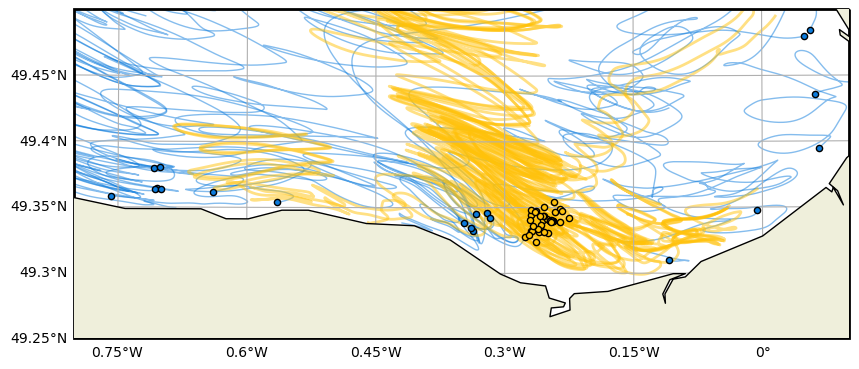

In [14]:
bounds=[-.8, .1, 49.25, 49.5]

fig, ax, cbar = cp.map(extent=bounds, rivers=False)
# rivers are not displayed correctly

for k, c in zip(keys, colors):
    _df = df.loc[k].set_index("time").sort_index()
    #c = "cadetblue" if "taos" in k else "0.5"
    c = c_taos if "taos" in k else c_lern
    lw = 2 if "taos" in k else 1
    #alpha = 1 if "taos" in k else 0.5
    ax.plot(_df.longitude, _df.latitude, color=c, label=k,
            alpha=0.5, lw=lw,
            transform=pin.maps.crs, 
           )

# add start locations
for k, c in zip(keys, colors):
    #c = "cadetblue" if "taos" in k else "0.1"
    c = c_taos if "taos" in k else c_lern
    _df = df.loc[k].set_index("time").sort_index()
    ax.scatter(_df.longitude.iloc[0], _df.latitude.iloc[0], color=c, transform=crs,
            edgecolor="k", s=20, zorder=10, marker="o", # zorder=10, 
           )